## Putting all tabula data work together

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

import os

import sys
script_directory = '/Users/joshwinnes/Library/Mobile Documents/com~apple~CloudDocs/Wheaton College/fall 2024/topics in data science/Math485/packages'
sys.path.append(script_directory)
import dhs_util
from dhs_util import *

os.chdir('/Users/joshwinnes/Library/Mobile Documents/com~apple~CloudDocs/Wheaton College/fall 2024/topics in data science/data')
df = pd.read_csv('dhs_service_records_synthesized_final.csv')

In [ ]:
os.chdir('/Users/yingli/Development/TopicsInDataScience/')
df = pd.read_csv('dhs_service_records_synthesized_final.csv')

df = dhs_preprocessing(df)
df, service_map = add_service_label(df)
df = add_age_bin(df)

recipient = get_recipient_attribute(df)
retention_cohort_count, retention_cohort_ratio = get_retention_cohort(df)
df_id_serv = get_id_service_matrix(df)

<Axes: xlabel='elapsed', ylabel='first_date'>

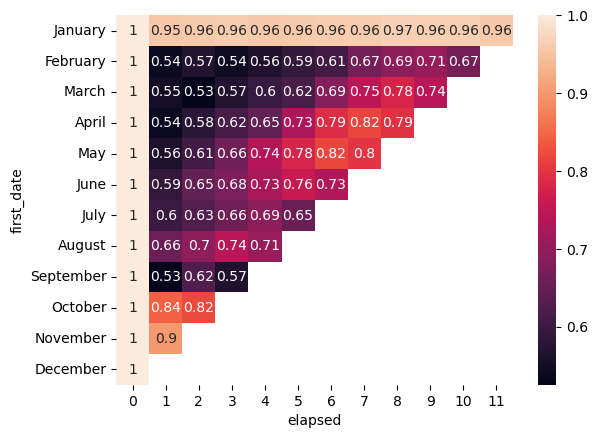

In [ ]:
sns.heatmap(retention_cohort_ratio, annot=True,
            yticklabels=pd.to_datetime(retention_cohort_ratio.index.values).month_name())

<Axes: xlabel='serv', ylabel='serv'>

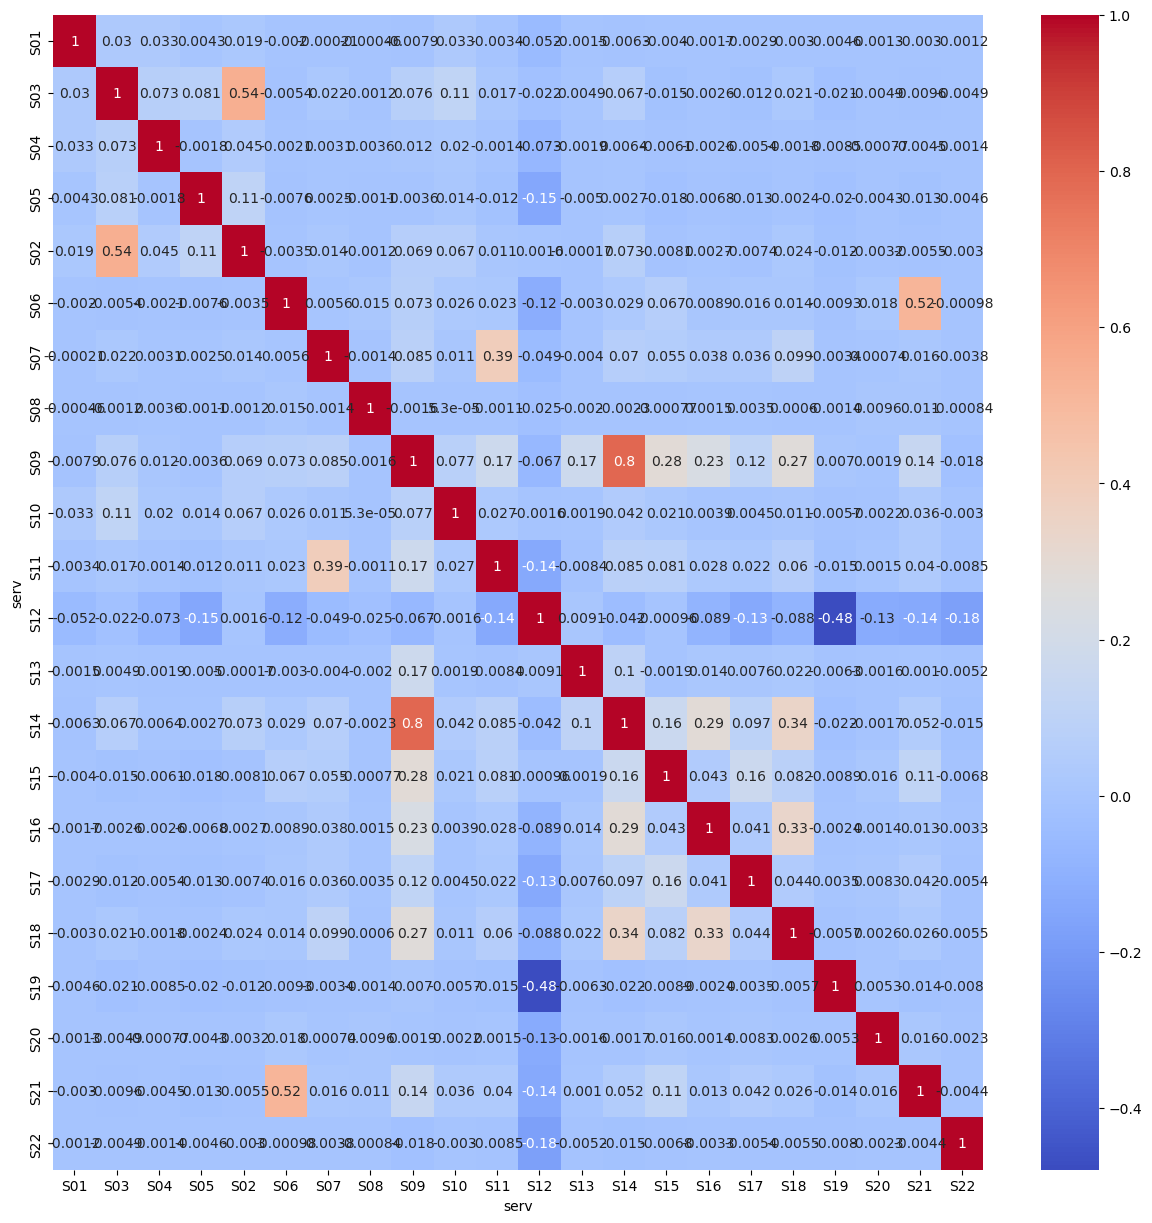

In [ ]:
plt.figure(figsize=(15,15)) 
sns.heatmap(df_id_serv.iloc[:,1:23].corr(method="spearman"),annot=True, cmap='coolwarm')

In [ ]:
from mlxtend.preprocessing import *
from mlxtend.frequent_patterns import association_rules
from mlxtend.frequent_patterns import fpgrowth
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import fpmax

In [ ]:
serv_oneHot = df_id_serv.iloc[:,1:23] > 0  # this converts value into True or False
min_freq = 1000
min_support = min_freq/serv_oneHot.shape[0]
min_confidence = 0.6
min_rule_support = 0.2
min_lift = 0.15

### use mlxtend package

### compute and print the association rules

In [ ]:

def serv_rules(freq_itemsets,metrics,threshold):
    asso_rules = association_rules(freq_itemsets, metric=metrics, min_threshold=threshold)
    return asso_rules.sort_values(by='lift', ascending=False)[['antecedents', 'consequents', 'support', 'confidence', 'lift']]

def predict(antecedent, rules, consequents_only = False):
    preds = rules[rules['antecedents'] == antecedent] # get the rules for this antecedent
    if consequents_only:
        preds = preds['consequents'].apply(iter).apply(next) # a way to convert a frozen set with one element to string
    return preds

In [ ]:
freq_itemset_apriori = apriori(serv_oneHot, use_colnames=True, min_support=min_support)\
    .sort_values(by="support", ascending=False)
freq_itemset_fpgrowth = fpgrowth(serv_oneHot,min_support=min_support,use_colnames=True)
freq_itemset_fpmax = fpmax(serv_oneHot,min_support=min_support,use_colnames=True)

rules_apriori = serv_rules(freq_itemset_apriori,"confidence",0.60)
rules_fpgrowth = serv_rules(freq_itemset_fpgrowth,"confidence",0.60)
rules_fpmax = association_rules(freq_itemset_fpmax, metric="confidence", min_threshold=0.001, support_only=True)

In [ ]:
predict({"S09"}, rules_apriori, consequents_only=False).head()

,antecedents,consequents,support,confidence,lift
1,(S09),(S14),0.103528,0.672938,6.500073
6,(S09),"(S12, S14)",0.094436,0.613843,6.500073
0,(S09),(S12),0.139131,0.904362,0.960634


In [ ]:
predict({"S09"}, rules_fpgrowth, consequents_only=False).head()

,antecedents,consequents,support,confidence,lift
14,(S09),"(S12, S14)",0.094436,0.613843,6.500073
8,(S09),(S14),0.103528,0.672938,6.500073
0,(S09),(S12),0.139131,0.904362,0.960634


In [ ]:
predict({"S09"}, rules_fpmax, consequents_only=False).head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
3,(S09),"(S02, S14)",NaN,NaN,0.001875,NaN,NaN,NaN,NaN,NaN
16,(S09),"(S03, S12, S02)",NaN,NaN,0.002182,NaN,NaN,NaN,NaN,NaN
23,(S09),"(S10, S12)",NaN,NaN,0.002754,NaN,NaN,NaN,NaN,NaN
36,(S09),"(S06, S12, S21)",NaN,NaN,0.002486,NaN,NaN,NaN,NaN,NaN
66,(S09),"(S07, S11, S12, S14)",NaN,NaN,0.002055,NaN,NaN,NaN,NaN,NaN


* one way to verify

In [ ]:
df[(df.serv=="S09")].merge(df[(df.serv =="S12")], on = "id").id.nunique()/df.id.nunique()

0.1391310212270911

### going through each service and print the rules with the service as antecedent 

In [ ]:
serv_list =  ['S'+str(i).zfill(2) for i in range(1,23)]
for i in serv_list:
    print(i)
    if (len(predict({i},rules_fpgrowth))>0):
        print(i), print(predict({i},rules_fpgrowth))

S01
S02
S02
    antecedents consequents   support  confidence       lift
204       (S02)  (S03, S12)  0.003921    0.935628  76.168573
200       (S02)       (S03)  0.004142    0.988377  72.213908
201       (S02)       (S12)  0.003970    0.947251   1.006192
S03
S03
   antecedents consequents   support  confidence      lift
16       (S03)       (S12)  0.012284    0.897482  0.953326
S04
S05
S05
    antecedents consequents   support  confidence      lift
175       (S05)       (S12)  0.008057    0.636996  0.676632
S06
S06
    antecedents consequents   support  confidence       lift
115       (S06)       (S21)  0.004582    0.784477  59.162639
S07
S07
    antecedents consequents   support  confidence       lift
141       (S07)  (S11, S12)  0.005105     0.79795  24.853835
137       (S07)       (S11)  0.006398     1.00000  24.460386
138       (S07)       (S12)  0.005105     0.79795   0.847601
S08
S09
S09
   antecedents consequents   support  confidence      lift
14       (S09)  (S12, S14)  0.094

In [ ]:
rules_fpgrowth.sort_values("support",ascending=False)


,antecedents,consequents,support,confidence,lift
0,(S09),(S12),0.139131,0.904362,0.960634
8,(S09),(S14),0.103528,0.672938,6.500073
9,(S14),(S09),0.103528,1.000000,6.500073
12,"(S09, S12)",(S14),0.094436,0.678758,6.556292
11,"(S09, S14)",(S12),0.094436,0.912184,0.968942
...,...,...,...,...,...
196,"(S18, S11)",(S14),0.001930,0.999030,9.649879
198,"(S18, S11, S14)",(S09),0.001930,1.000000,6.500073
197,"(S09, S11, S18)",(S14),0.001930,0.999030,9.649879
211,"(S02, S14)",(S09),0.001875,1.000000,6.500073


# review

* compare numerical variables across different groups that is encoded in a caategorical variable 

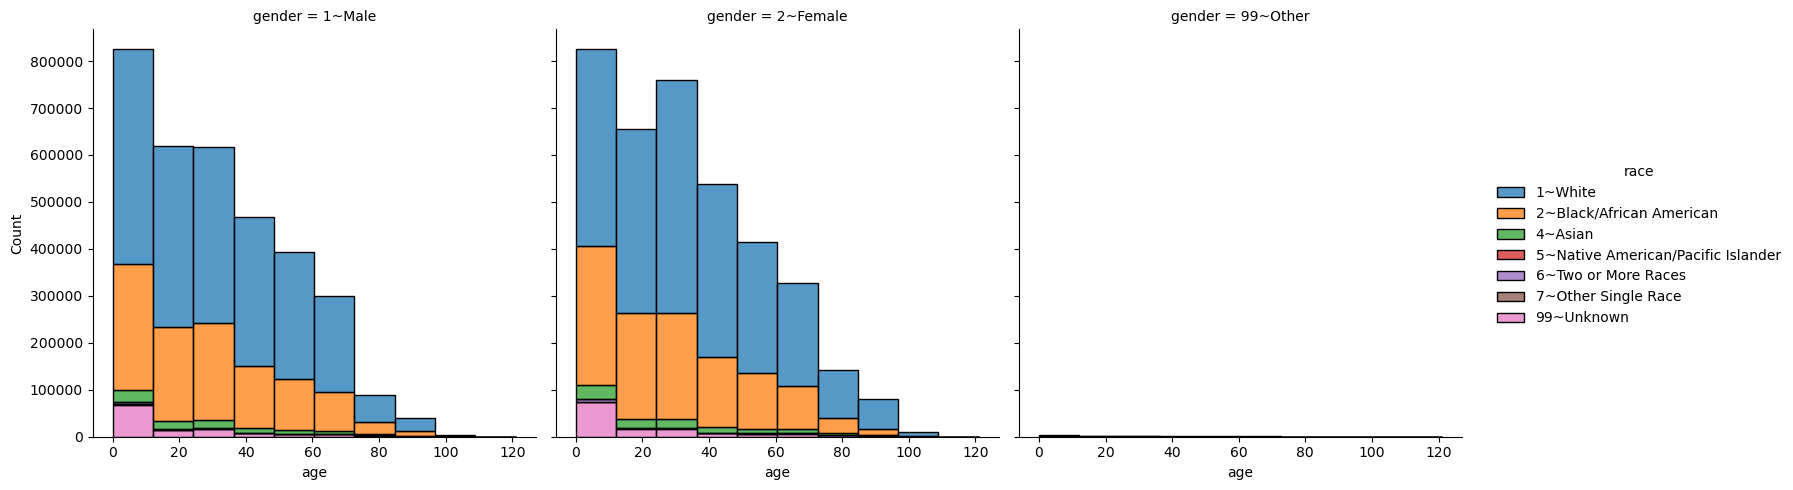

In [ ]:
sns.displot(data = df, x = 'age', bins = 10, hue = 'race', col = 'gender', multiple="stack")

In [ ]:
df.query("gender != '99~Other'").shape

(7107283, 12)

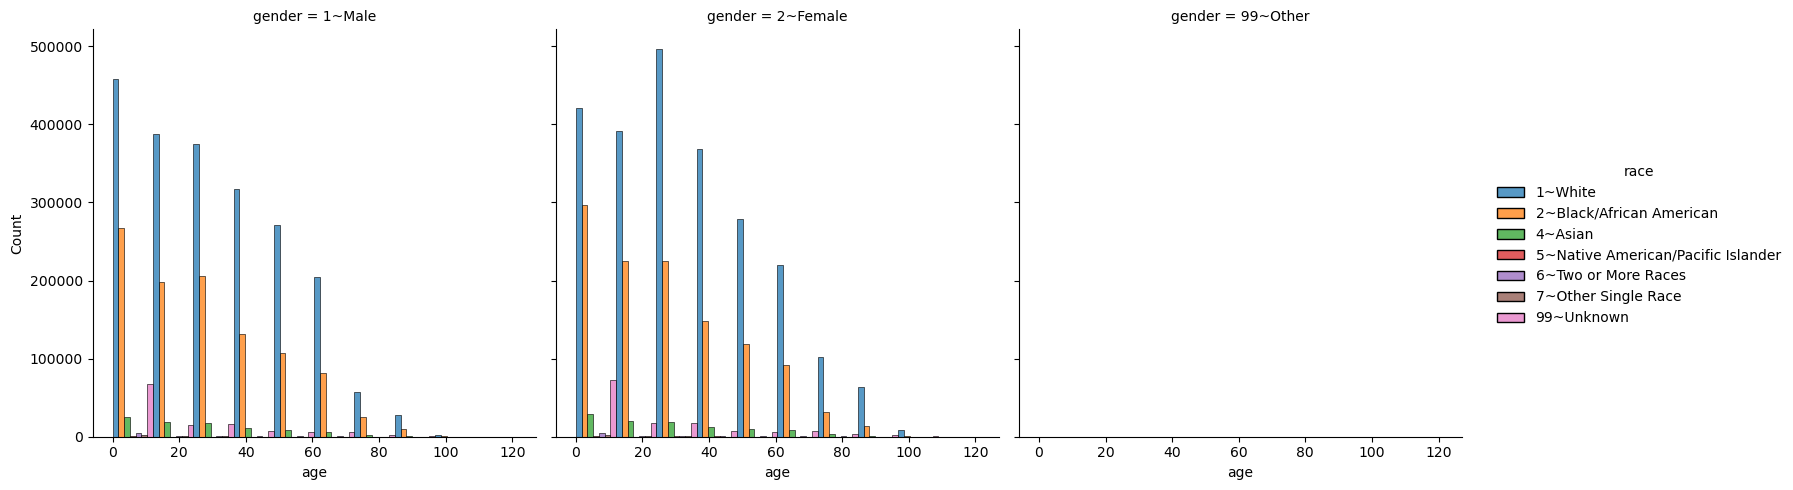

In [ ]:
sns.displot(data = df.query("gender != '99~Other'"), x = 'age', bins = 10, hue = 'race', col = 'gender', multiple="dodge")
plt.savefig("/Users/yingli/Development/TopicsInDataScience/hist.png")


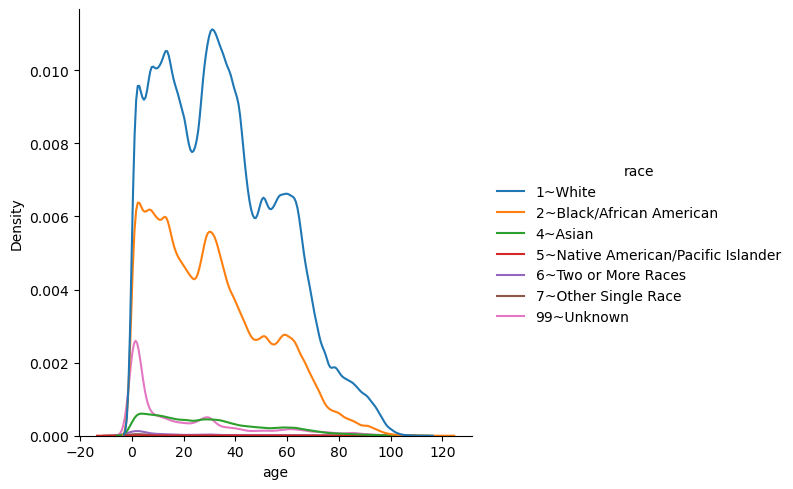

In [ ]:
sns.displot(data = df, x = 'age', hue = 'race', kind='kde')
plt.show()

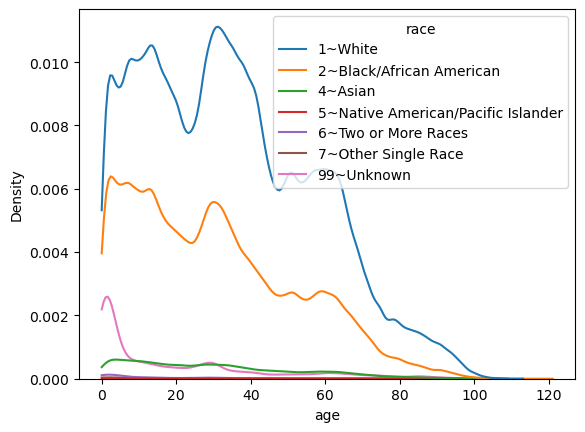

In [ ]:
sns.kdeplot(data = df, x = 'age', hue = 'race',cut=0)
plt.show()

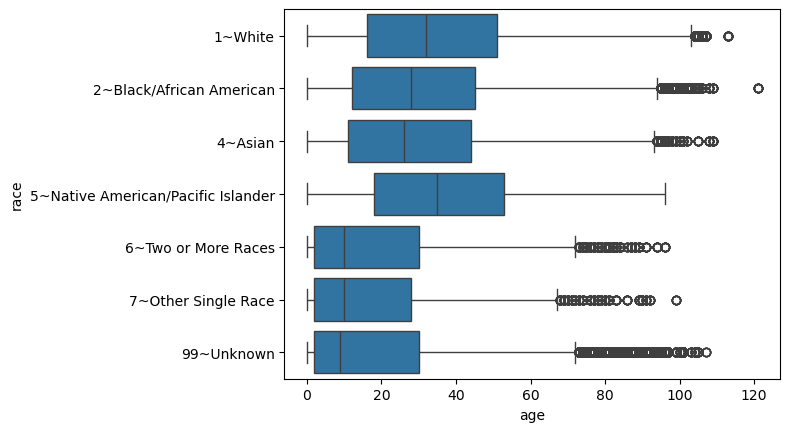

In [ ]:
sns.boxplot(data = df, x = 'age', y = 'race')
plt.show()

### a good practice to add title, x-lable, y-label to the chart

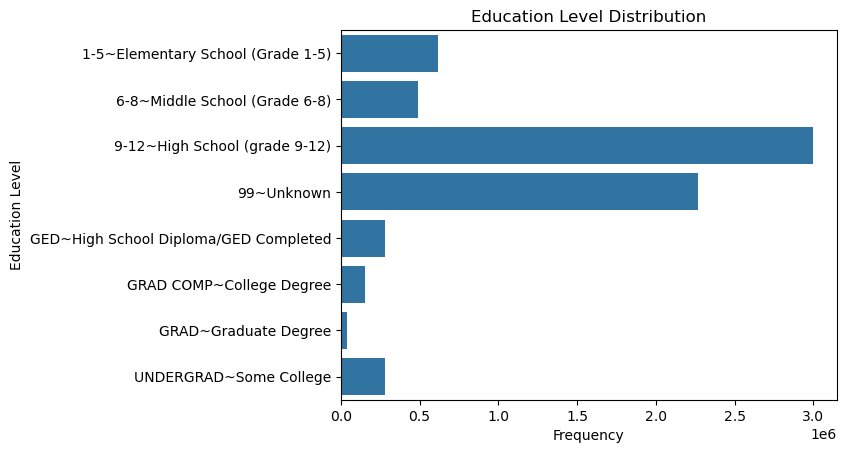

In [ ]:
sns.countplot(df, y='education') 
plt.title('Education Level Distribution')
plt.ylabel('Education Level')
plt.xlabel('Frequency')
plt.show()

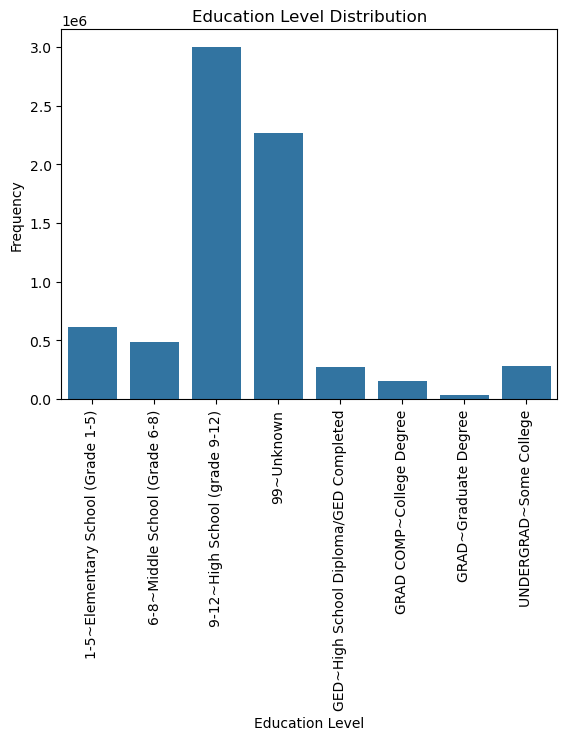

In [ ]:
sns.countplot(x = df['education'])
plt.title('Education Level Distribution')
plt.xlabel('Education Level')
plt.xticks(rotation=90)
plt.ylabel('Frequency')
plt.show()

* heatmaps: two categorical (for plot row and column), one numerical value to use numerical functions, or one categorical value to use "count" to get to numerical value

<Axes: xlabel='serv', ylabel='first_date'>

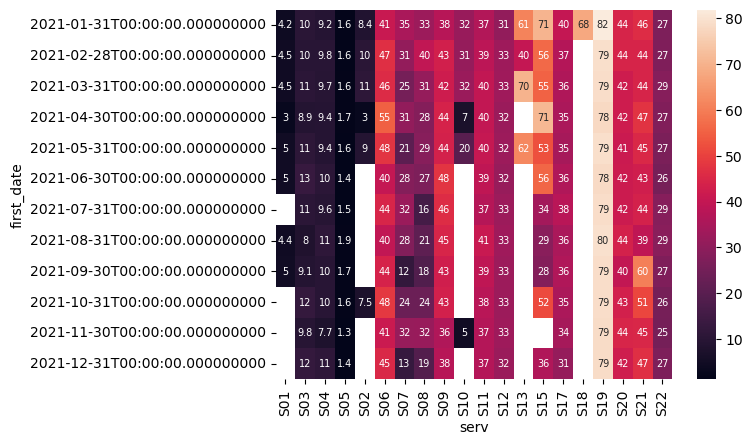

In [ ]:
sns.heatmap(recipient.pivot_table(observed=False,index = ['first_date'], columns='serv', values = 'age',aggfunc='mean'),
            annot=True, annot_kws={'size': 7})

<Axes: xlabel='serv', ylabel='race-gender'>

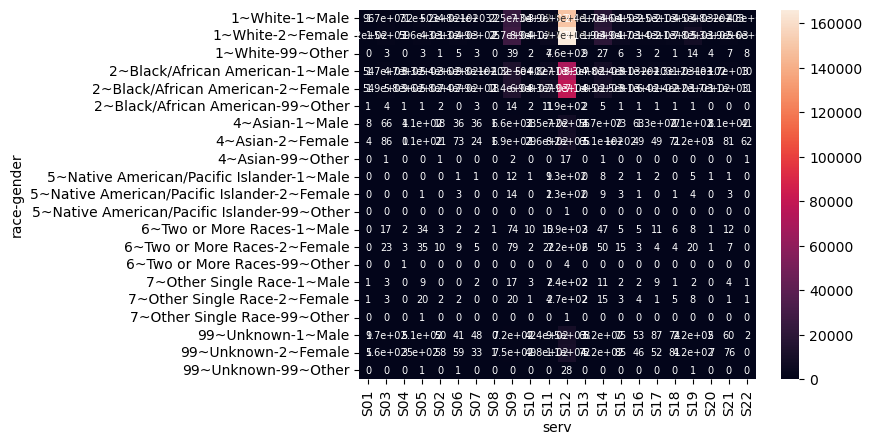

In [ ]:
sns.heatmap(df.pivot_table(observed=False,index = ['race','gender'], columns='serv', values = 'id',aggfunc='nunique'),
            annot=True, annot_kws={'size': 7})

<Axes: xlabel='serv', ylabel='race-gender'>

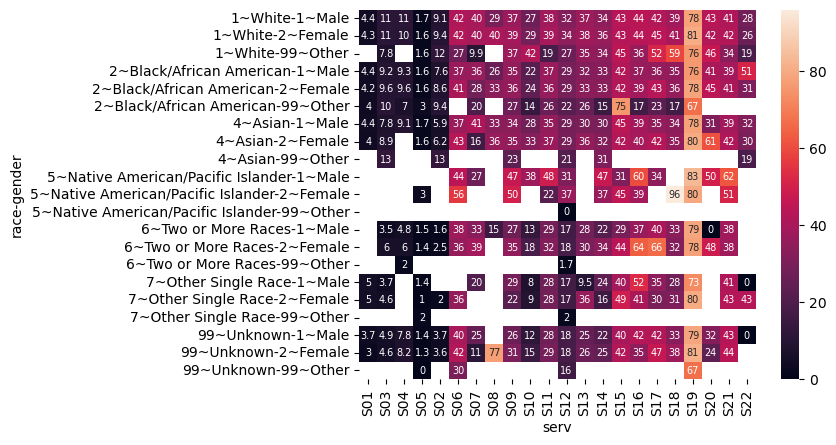

In [ ]:
sns.heatmap(df.pivot_table(observed=False,index = ['race','gender'], columns='serv', values = 'age',aggfunc='mean'),
            annot=True, annot_kws={'size': 7})

<Axes: xlabel='distinct_service', ylabel='num_service'>

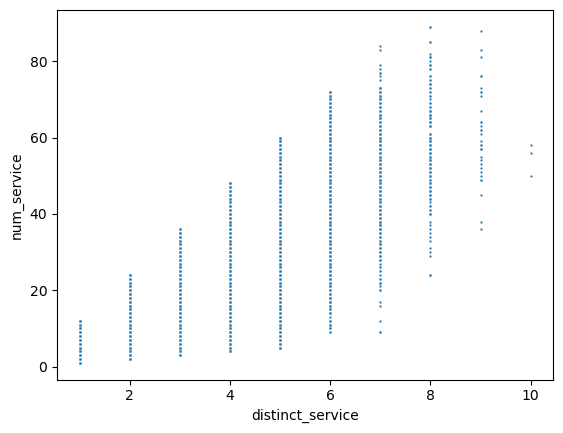

In [ ]:
sns.scatterplot(recipient, x='distinct_service', y='num_service', s=3)

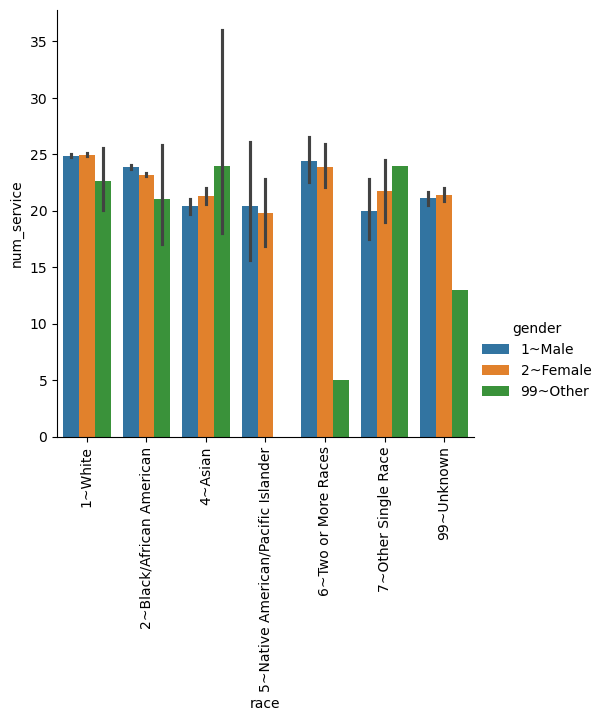

In [ ]:
sns.catplot(data = recipient.query("distinct_service > 1"), 
            x="race", y="num_service", hue="gender",kind="bar")
plt.xticks(rotation=90)
plt.show()

In [ ]:
print("hello")

hello
